This notebook supports the Fig. 6A of the Review "Blastocoel morphogenesis: a biophysics perspective" (Le Verge--Serandour, Turlier, 2021). We provide the model and the numerical code used to produce the figure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

from scipy.integrate import odeint

# Model
We consider a cell with radius $R$ and internal concentration $C_{\rm{in}}$ of a non-charged solute, immersed in a medium with concentration $C_{\rm{out}}$. The membrane of the cell allows water and solute to go through with permeation $\lambda_v$ and $\lambda_s$ respectively. This semi-permeable membrane creates an osmotic pressure $\Delta \Pi = \mathcal{R}T \left(C_{\rm{in}} - C_{\rm{out}}\right)$, given by the Van't Hoff relation. The cell has internal pressure $P_{\rm{in}}$, and external pressure is $P_{\rm{out}}$, given by the Laplace's law $\Delta P = P_{\rm{in}} - P_{\rm{out}} = \frac{2 \gamma}{R}$, where $\gamma$ is the surface tension of the membrane. 

The radius evolution is given by the water movement, generated by the competition between osmotic pressure difference versus hydraulic pressure difference:

$$\frac{dR}{dt} = \lambda_v\left[ \mathcal{R}T \left(C_{\rm{in}} - C_{\rm{out}}\right) - \left(P_{\rm{in}} - P_{\rm{out}}\right)\right]  \tag{1}$$ 

Solute is imported or exported due to chemical potential difference $\lambda_s \mathcal{R}T \log\left(\frac{C_{\rm{out}}}{C_{\rm{in}}}\right) $, or actively pumped at constant rate $j_s$ :

$$\frac{dC_{\rm{in}}}{dt} = 4 \pi R^2 \left[\lambda_s \mathcal{R}T \log\left(\frac{C_{\rm{out}}}{C_{\rm{in}}}\right) + j_s\right] \tag{2}$$

# Non-dimensionalized system
We solve the couple of differential equations, that describe time evolution of the non-dimensionalized cell radius $\bar{R}(t)=/R_{0}$ and non-dimensionalized cell concentration $\bar{C}(t)=C_{in}(t)/C_{\rm{out}}$ :

$$\frac{d \bar{R}}{d\bar{t}} = \left[\delta \bar{C} - \frac{\epsilon}{\bar{R}} \right] \tag{3}$$

$$\frac{\tau_s}{\tau_v} \frac{d \delta \bar{C}}{dt} = \bar{R}^2 \left[\bar{j}_s - \delta \bar{C} \right] \tag{4}$$

where $\bar{t} = t / \tau_v$, $\delta \bar{C} = \bar{C} - 1$, the pumping constant $\bar{j}_s$, and parameter 
$$\epsilon = \frac{2\gamma/R_0}{\mathcal{R}T C_{\rm{out}}} \tag{5}$$
that compares hydraulic over osmotic typical pressures, the water relaxation time
$$\tau_v = \frac{R_0}{\lambda_v \mathcal{R}T C_0} \tag{6}$$
and solute relaxation time
$$\tau_s = \frac{C_0}{4\pi R_0^2 \lambda_s\mathcal{R}T} \tag{7}$$

### Remarks
- Typically, $C_{\rm{out}}, C_{\rm{in}} \sim 100 mM$, and $C_{\rm{in}} - C_{\rm{out}} \ll C_{\rm{out}}$ : the cell is close from osmotic equilibrium. This allows to write 
$$\begin{align*}
\log \left(\frac{C_{\rm{out}}}{C_{\rm{in}}}\right) &= \log \left(\frac{C_{\rm{out}}}{C_{\rm{in}} - C_{\rm{out}} + C_{\rm{out}}}\right) = \log \left(\frac{1}{\delta \bar{C}+ 1}\right) \\
&\underset{\delta \bar{C} \ll 1}{=} -\delta \bar{C}
\end{align*}$$
- As mentionned in the main manuscript, $P_{\rm{in}} \simeq 10^{2-3} \rm{Pa}$ and $\Pi_0 = \mathcal{R}TC_{\rm{out}} \simeq 10^5 \rm{Pa}$, thus, typically, $\epsilon \sim 10^{-2}$

# Stationnary state

The stationary state is given by $\dot{\bar{R}} = \dot{\bar{C}} = 0$, leading to the pumping threshold
$$\bar{j}^* = \frac{\epsilon}{\bar{R}}$$
Above this threshold, the cell pumps a lot of solute that makes it expanding, below, it shrinks to zero.

Indeed, the osmotic equilibrium is found for 
$$\delta \bar{C} = \bar{j}_s \Leftrightarrow \mathcal{R}T\Delta C = \frac{j_s}{\lambda_s C_{\rm{out}}}$$
ie, the active pumping imposes a constant osmotic load on the cell. This is compensated if and only if the hydrostatic pressure $\epsilon/\bar{R} = \delta \bar{C} \Leftrightarrow \frac{2 \gamma}{R} = \frac{\Delta C}{\Pi_0 C_{\rm{out}}}$ is equal to this osmotic load. Thus, if
- $j_s > j^*$ : the active pumping imposes a higher pressure than the Laplace's pressure and the cell expands.
- $j_s < j^*$ : the active pumping does not generate a sufficient pressure able to overcome the Laplace's pressure and the cell shrinks.

In [2]:
def dRdt(t, R, deltaC, eps, tauv) :
    return (deltaC - eps/R)/tauv

def dCdt(t, R, deltaC, js, taus) :
    return R * R * (js - deltaC)/taus

def dCdt_2(t, R, deltaC, js, taus) :
    return R * R * (js - np.log(1.+deltaC) )/taus

def f(Y, t, eps, js, taus, tauv) :
    R, deltaC = Y
    if R < 0 or deltaC < 0 :
        return [None, None]
    #eps, js, taus, tauv = args
    dR = dRdt(t, R, deltaC, eps, tauv)
    dC = dCdt(t, R, deltaC, js, taus)
    #dC = dCdt_2(t, R, deltaC, js, taus)
    return [dR, dC]


Pumping threshold  js =  0.1


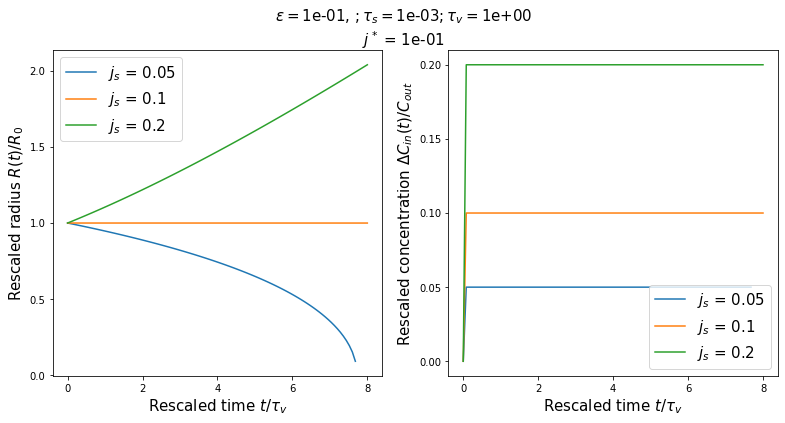

In [3]:
R0, deltaC0 = 1., 0.

eps = 1e-1
taus, tauv = 1e-3, 1.

t = np.linspace(0., 8., 101)


jstar = eps/R0
print('Pumping threshold ', 'js = ', jstar)

js_list = np.array([0.5, 1., 2.])*jstar

fig, ax = plt.subplots(1,2, figsize=(13,6))

for js in js_list:
    y0 = [R0, deltaC0]
    sol = odeint(f, y0, t, args=(eps, js, taus, tauv))
    ax[0].plot(t, sol[:, 0], label = r'$j_s$ = '+str(js))
    ax[1].plot(t, sol[:, 1], label = r'$j_s$ = '+str(js))
    
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[0].xaxis.set_major_locator(MaxNLocator(5))
ax[1].xaxis.set_major_locator(MaxNLocator(5))
ax[0].yaxis.set_major_locator(MaxNLocator(5))
ax[1].yaxis.set_major_locator(MaxNLocator(5))

ax[0].set_xlabel(r'Rescaled time $t/\tau_v$', fontsize=15)
ax[1].set_xlabel(r'Rescaled time $t/\tau_v$', fontsize=15)
ax[0].set_ylabel(r'Rescaled radius $R(t)/R_0$', fontsize=15)
ax[1].set_ylabel(r'Rescaled concentration $\Delta C_{in}(t)/C_{out}$', fontsize=15)

plt.suptitle(r'$\epsilon=$'+"{:2.0e}".format(eps)+r', $ ; \tau_s = $'+"{:2.0e}".format(taus)+ r'$ ; \tau_v =$'+"{:2.0e}".format(tauv) + '\n' + r'$j^*$ = '+"{:2.0e}".format(jstar), fontsize=15)
#plt.savefig('pumping_threshold.eps', format='eps')

plt.show()


We plot above the radius versus time for three cases of active pumping with the same initial conditions $\bar{R} = 1$, $\bar{C} = 1$, with parameters $\epsilon = 0.1$, $\tau_v = 1 s$, $\tau_s = 0.001 s$.

The pumping threshold is $\bar{j}^*_s = 0.1$.

## Another example with similar times.

Pumping threshold  js =  0.01


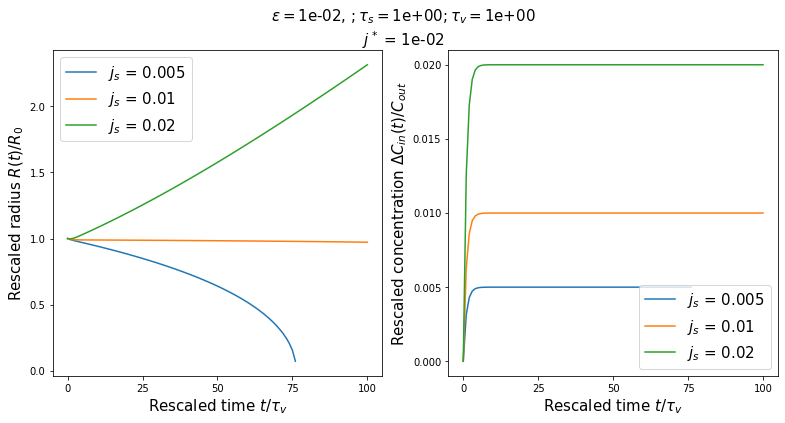

In [4]:
R0, deltaC0 = 1., 0.

eps = 1e-2
taus, tauv = 1., 1.

t = np.linspace(0., 100., 101)


jstar = eps/R0
print('Pumping threshold ', 'js = ', jstar)

js_list = np.array([0.5, 1., 2.])*jstar

fig, ax = plt.subplots(1,2, figsize=(13,6))

for js in js_list:
    y0 = [R0, deltaC0]
    sol = odeint(f, y0, t, args=(eps, js, taus, tauv))
    ax[0].plot(t, sol[:, 0], label = r'$j_s$ = '+str(js))
    ax[1].plot(t, sol[:, 1], label = r'$j_s$ = '+str(js))
    
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[0].xaxis.set_major_locator(MaxNLocator(5))
ax[1].xaxis.set_major_locator(MaxNLocator(5))
ax[0].yaxis.set_major_locator(MaxNLocator(5))
ax[1].yaxis.set_major_locator(MaxNLocator(5))

ax[0].set_xlabel(r'Rescaled time $t/\tau_v$', fontsize=15)
ax[1].set_xlabel(r'Rescaled time $t/\tau_v$', fontsize=15)
ax[0].set_ylabel(r'Rescaled radius $R(t)/R_0$', fontsize=15)
ax[1].set_ylabel(r'Rescaled concentration $\Delta C_{in}(t)/C_{out}$', fontsize=15)

plt.suptitle(r'$\epsilon=$'+"{:2.0e}".format(eps)+r', $ ; \tau_s = $'+"{:2.0e}".format(taus)+ r'$ ; \tau_v =$'+"{:2.0e}".format(tauv) + '\n' + r'$j^*$ = '+"{:2.0e}".format(jstar), fontsize=15)
#plt.savefig('pumping_threshold.eps', format='eps')

plt.show()

